<a href="https://colab.research.google.com/github/durai123kd/DURAI.DS/blob/main/Shanmugapriya%20DS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
borismarjanovic_price_volume_data_for_all_us_stocks_etfs_path = kagglehub.dataset_download('borismarjanovic/price-volume-data-for-all-us-stocks-etfs')
szrlee_stock_time_series_20050101_to_20171231_path = kagglehub.dataset_download('szrlee/stock-time-series-20050101-to-20171231')
camnugent_sandp500_path = kagglehub.dataset_download('camnugent/sandp500')
aaron7sun_stocknews_path = kagglehub.dataset_download('aaron7sun/stocknews')
rhesamulyadi_idx_30_stocks_price_history_path = kagglehub.dataset_download('rhesamulyadi/idx-30-stocks-price-history')

print('Data source import complete.')

100%|██████████| 19.3M/19.3M [00:00<00:00, 75.7MB/s]

Extracting files...


100%|██████████| 5.82M/5.82M [00:00<00:00, 47.7MB/s]

Extracting files...


100%|██████████| 1.61M/1.61M [00:00<00:00, 110MB/s]

Extracting files...
Data source import complete.


In [2]:
!pip install pandas_datareader
!pip install yfinance

In [3]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

from pandas_datareader.data import DataReader

import warnings
warnings.simplefilter("ignore")

set_seed(455)
np.random.seed(455)

Download Apple's stock market prices.

In [4]:
end = datetime.now()
start = datetime(2016, end.month, end.day)
dataset = yf.download("AAPL", start, end)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [5]:
dataset

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2016-05-16,21.456535,21.573098,20.946864,21.115992,245039200
2016-05-17,21.367399,21.643948,21.257695,21.609666,187667600
2016-05-18,21.611948,21.760508,21.458818,21.520528,168249600
2016-05-19,21.529669,21.630233,21.385681,21.630233,121768400
2016-05-20,21.762794,21.810790,21.602807,21.630233,128104000
...,...,...,...,...,...
2025-05-09,198.270004,200.277366,197.281295,198.739390,36453900
2025-05-12,210.789993,211.270004,206.750000,210.970001,63775800


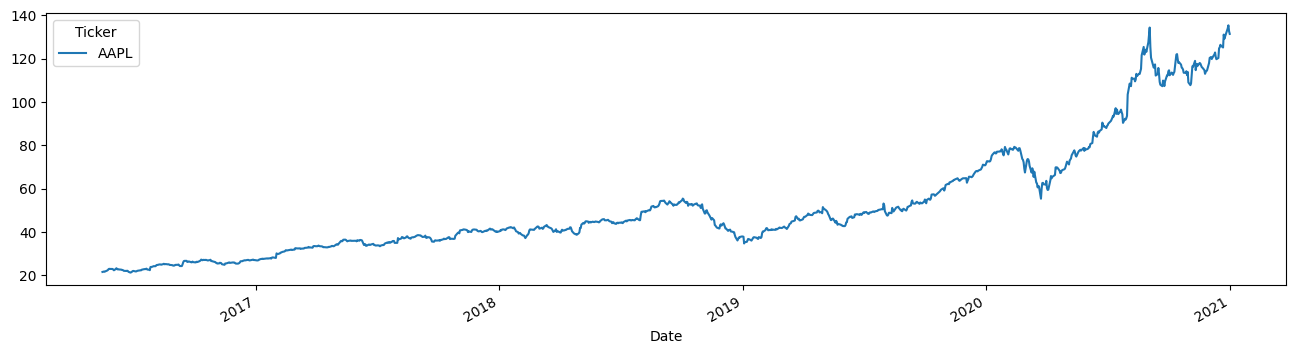

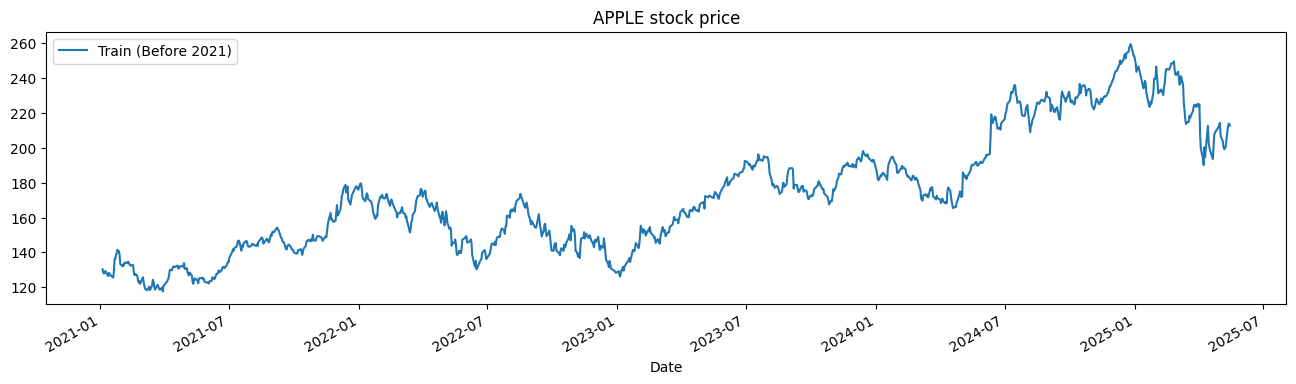

In [6]:
tstart = 2016
tend = 2020

def train_test_plot(dataset, tstart, tend):
    dataset.loc[f"{tstart}":f"{tend}", "High"].plot(figsize=(16, 4), legend=True)
    dataset.loc[f"{tend+1}":, "High"].plot(figsize=(16, 4), legend=True)
    plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
    plt.title("APPLE stock price")
    plt.show()

train_test_plot(dataset,tstart,tend)

In [7]:
def train_test_split(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}", "High"]
    test = dataset.loc[f"{tend+1}":, "High"]
    return train, test

def train_test_split_values(dataset, tstart, tend):
    train, test =  train_test_split(dataset, tstart, tend)
    return train.values, test.values

training_set, test_set = train_test_split_values(dataset, tstart, tend)

In [8]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

In [9]:
def split_sequence(sequence, window):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + window
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

window_size = 60
features = 1

X_train, y_train = split_sequence(training_set_scaled, window_size)

In [10]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)

# RNN

RNN stands for Recurrent Neural Network, a type of artificial neural network designed to work with sequences of data, such as time series or natural language. Unlike feedforward neural networks, which process input data in a single pass and generate output, RNNs maintain a hidden state that can capture information from previous inputs in the sequence. This allows them to exhibit temporal dynamic behavior and learn patterns or dependencies over time.

RNNs consist of interconnected layers of neurons, with recurrent connections that allow information to loop back within the network. This recurrent nature enables the network to "remember" previous inputs and use that information in processing subsequent inputs. However, RNNs can suffer from issues like vanishing or exploding gradients, which make it difficult for them to learn long-range dependencies.

To address these limitations, more advanced variants of RNNs, such as Long Short-Term Memory (LSTM) networks and Gated Recurrent Units (GRUs), have been developed. These architectures introduce specialized gating mechanisms that help to control the flow of information, making it easier to capture and learn from long-range dependencies in the data.

# LTSM

In [11]:
model_lstm = Sequential()
model_lstm.add(LSTM(units=125, activation="tanh", input_shape=(window_size, features)))
model_lstm.add(Dense(25))
model_lstm.add(Dense(units=1))

model_lstm.compile(optimizer='adam', loss='mse')

model_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 125)            │        63,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         3,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,676 (260.45 KB)

 Trainable params: 66,676 (260.45 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model_lstm.fit(X_train, y_train, epochs=15, batch_size=32)

Epoch 1/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.0269
Epoch 2/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 6.1716e-04
Epoch 3/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 4.8312e-04
Epoch 4/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 4.8902e-04
Epoch 5/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 4.7421e-04
Epoch 6/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 4.4437e-04
Epoch 7/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 4.2388e-04
Epoch 8/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 4.1120e-04
Epoch 9/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 4.0141e-04
Epoch 10/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 3.9344e-04
Epoch 11/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 3.8646e-04
Epoch 12/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 3.7985e-04
Epoch 13/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 3.7296e-04
Epoch 14/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.6527e-04
Epoch 15/15
35/35 ━

In [13]:
dataset_total = dataset.loc[:,"High"]
inputs = dataset_total[len(dataset_total) - len(test_set) - window_size :].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)

In [14]:
X_test, y_test = split_sequence(inputs, window_size)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)
predicted_stock_price = model_lstm.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y_test = sc.inverse_transform(y_test)

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


In [15]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.show()


def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))

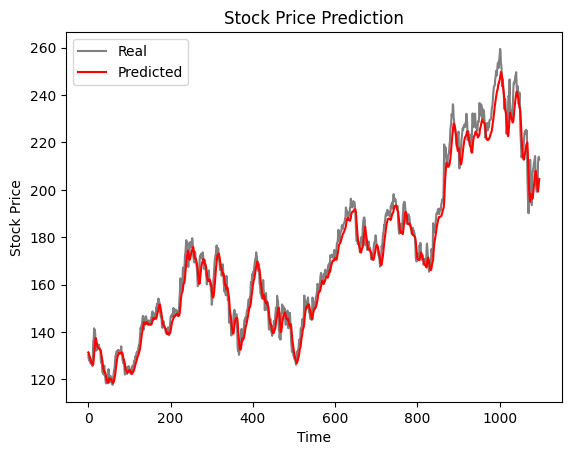

In [16]:
plot_predictions(y_test,predicted_stock_price)

In [17]:
return_rmse(y_test,predicted_stock_price)

The root mean squared error is 5.07.


# GRU

In [18]:
model_gru = Sequential()
model_gru.add(GRU(units=125, activation="tanh", input_shape=(window_size, features)))
model_gru.add(Dense(units=1))

model_gru.compile(optimizer="adam", loss="mse")

model_gru.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 125)            │        48,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           126 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,126 (187.99 KB)

 Trainable params: 48,126 (187.99 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model_gru.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0429
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 7.7968e-04
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 3.3001e-04
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 3.4532e-04
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 3.4938e-04
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 3.4401e-04
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 3.2837e-04
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 3.1365e-04
Epoch 9/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 3.0363e-04
Epoch 10/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 2.9600e-04


In [20]:
GRU_predicted_stock_price = model_gru.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


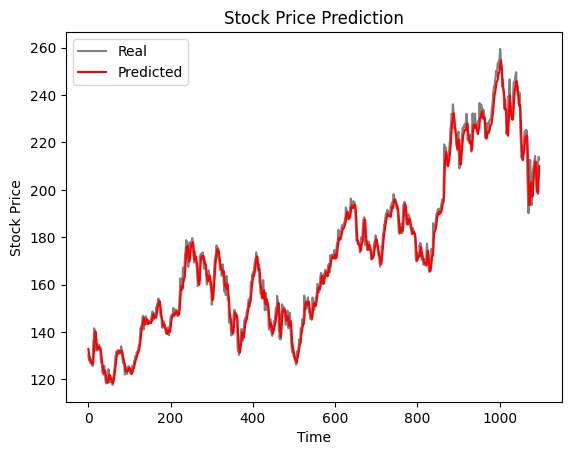

In [21]:
plot_predictions(y_test, GRU_predicted_stock_price)

In [22]:
return_rmse(y_test,GRU_predicted_stock_price)

The root mean squared error is 3.83.


Conclusion: GRU lead to better results.